# High-Performance DeiT for Bean Leaf Classification


In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import timm
from timm.utils import ModelEmaV2

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.auto import tqdm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Device: cuda
GPU: Tesla P100-PCIE-16GB


In [3]:
BASE_DIR = '/kaggle/input/bean-leaf-lesions-classification'
TRAIN_DIR = f'{BASE_DIR}/train'
VAL_DIR = f'{BASE_DIR}/val'
OUTPUT_DIR = '/kaggle/working/results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_HEIGHT = 384
IMG_WIDTH = 384
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.05
LABEL_SMOOTHING = 0.1
WARMUP_EPOCHS = 2
PATIENCE = 5
EMA_DECAY = 0.9998
GRAD_CLIP = 1.0
NUM_CLASSES = 3

## Data Transforms and Loaders

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05),
            shear=0,
            interpolation=transforms.InterpolationMode.BICUBIC,
            fill=0
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.0,
            saturation=0.0,
            hue=0.0
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(VAL_DIR, transform=data_transforms['val'])

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

class_names = train_dataset.classes
print(f'Classes: {class_names}')
print(f'Train samples: {len(train_dataset)}')
print(f'Val samples: {len(val_dataset)}')
print(f'Class indices: {train_dataset.class_to_idx}')

Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Train samples: 1034
Val samples: 133
Class indices: {'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}


## Model Setup with EMA

Đoạn code khởi tạo model DeiT3-Small (Data-efficient Image Transformer) với input 384x384 pixels từ thư viện timm. Model được load pretrained weights từ Facebook (fb_in1k - trained on ImageNet-1K) và điều chỉnh num_classes cho bài toán phân loại 3 lớp bệnh lá đậu. Sau đó, Exponential Moving Average (EMA) được áp dụng thông qua ModelEmaV2 với decay rate để tạo phiên bản "smoothed" của model weights - kỹ thuật này giúp ổn định quá trình training và thường cho kết quả inference tốt hơn model gốc. Model được chuyển sang GPU (device) để tăng tốc huấn luyện.

In [7]:
model = timm.create_model(
    'deit3_small_patch16_384.fb_in1k',
    pretrained=True,
    num_classes=NUM_CLASSES
)
model = model.to(device)

model_ema = ModelEmaV2(model, decay=EMA_DECAY, device=device)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

model.safetensors:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

Model parameters: 21,821,571
Trainable parameters: 21,821,571


## Optimizer, Scheduler, Loss

Hàm loss CrossEntropyLoss với Label Smoothing giúp model không quá tự tin vào dự đoán, cải thiện generalization. Optimizer AdamW kết hợp adaptive learning rate với Weight Decay để regularization hiệu quả hơn L2 thông thường. Learning rate scheduler sử dụng chiến lược Warmup + Cosine Annealing: trong giai đoạn warmup, LR tăng tuyến tính từ 0 đến LEARNING_RATE để tránh gradient explosion khi weights chưa ổn định; sau warmup, LR giảm theo hàm cosine từ giá trị đỉnh xuống gần 0, giúp model hội tụ mượt mà và tránh local minima. Đây là lịch trình LR tiêu chuẩn cho Vision Transformers, được chứng minh hiệu quả trong các paper gốc của DeiT.

In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = len(train_loader) * WARMUP_EPOCHS

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

## Training Functions

Hàm train_one_epoch thực hiện một epoch huấn luyện với các bước: forward pass để tính loss, backward pass để tính gradient, Gradient Clipping (clip_grad_norm_) để ngăn gradient explosion - đặc biệt quan trọng với Transformers có nhiều layers. Sau mỗi step, optimizer cập nhật weights, scheduler điều chỉnh learning rate, và EMA model được cập nhật với weights mới. Hàm validate đánh giá model với decorator @torch.no_grad() để tắt gradient computation, tiết kiệm bộ nhớ và tăng tốc inference. Kết quả trả về bao gồm loss, accuracy và predictions để tính các metrics như confusion matrix, classification report.

In [9]:
def train_one_epoch(model, model_ema, loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        
        optimizer.step()
        scheduler.step()
        model_ema.update(model)
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in tqdm(loader, desc='Validating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

## Training Loop

Training loop theo dõi cả model gốc và EMA model song song, lưu lại history của 6 metrics (train/val loss và accuracy cho cả hai phiên bản). Mỗi epoch, sau khi train xong sẽ validate trên cả model gốc và EMA model để so sánh hiệu suất. Chiến lược lưu model thông minh: chỉ lưu phiên bản nào có accuracy cao hơn (model gốc hoặc EMA), đảm bảo luôn giữ được kết quả tốt nhất. Early Stopping được implement thủ công với patience counter - nếu accuracy không cải thiện sau số epoch quy định (PATIENCE), training sẽ dừng sớm để tránh overfitting và tiết kiệm thời gian. Đây là best practice cho training Transformers: kết hợp EMA + Early Stopping để đạt kết quả tối ưu.

In [10]:
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'ema_val_loss': [], 'ema_val_acc': []
}

best_acc = 0.0
best_ema_acc = 0.0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 40)
    
    train_loss, train_acc = train_one_epoch(
        model, model_ema, train_loader, criterion, optimizer, scheduler, device
    )
    
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    ema_val_loss, ema_val_acc, preds, labels = validate(model_ema.module, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['ema_val_loss'].append(ema_val_loss)
    history['ema_val_acc'].append(ema_val_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f'LR: {current_lr:.6f}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'EMA Val Loss: {ema_val_loss:.4f} | EMA Val Acc: {ema_val_acc:.2f}%')
    
    current_best = max(val_acc, ema_val_acc)
    if current_best > best_acc:
        best_acc = current_best
        patience_counter = 0
        if ema_val_acc >= val_acc:
            torch.save(model_ema.module.state_dict(), f'{OUTPUT_DIR}/best_deit_ema.pth')
            print(f'Saved EMA model with acc: {ema_val_acc:.2f}%')
        else:
            torch.save(model.state_dict(), f'{OUTPUT_DIR}/best_deit.pth')
            print(f'Saved model with acc: {val_acc:.2f}%')
    else:
        patience_counter += 1
        print(f'No improvement. Patience: {patience_counter}/{PATIENCE}')
    
    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\nBest Validation Accuracy: {best_acc:.2f}%')


Epoch 1/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000050
Train Loss: 0.9053 | Train Acc: 57.45%
Val Loss: 0.5245 | Val Acc: 89.47%
EMA Val Loss: 1.2316 | EMA Val Acc: 33.83%
Saved model with acc: 89.47%

Epoch 2/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000100
Train Loss: 0.4254 | Train Acc: 93.71%
Val Loss: 0.3304 | Val Acc: 99.25%
EMA Val Loss: 1.2242 | EMA Val Acc: 35.34%
Saved model with acc: 99.25%

Epoch 3/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000099
Train Loss: 0.3632 | Train Acc: 96.42%
Val Loss: 0.3114 | Val Acc: 99.25%
EMA Val Loss: 1.2158 | EMA Val Acc: 35.34%
No improvement. Patience: 1/5

Epoch 4/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000097
Train Loss: 0.3393 | Train Acc: 97.87%
Val Loss: 0.3154 | Val Acc: 98.50%
EMA Val Loss: 1.2067 | EMA Val Acc: 36.09%
No improvement. Patience: 2/5

Epoch 5/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000093
Train Loss: 0.3387 | Train Acc: 97.87%
Val Loss: 0.3452 | Val Acc: 96.24%
EMA Val Loss: 1.1977 | EMA Val Acc: 36.09%
No improvement. Patience: 3/5

Epoch 6/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000088
Train Loss: 0.3325 | Train Acc: 98.16%
Val Loss: 0.3170 | Val Acc: 98.50%
EMA Val Loss: 1.1884 | EMA Val Acc: 36.84%
No improvement. Patience: 4/5

Epoch 7/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000082
Train Loss: 0.3350 | Train Acc: 98.16%
Val Loss: 0.2936 | Val Acc: 100.00%
EMA Val Loss: 1.1789 | EMA Val Acc: 38.35%
Saved model with acc: 100.00%

Epoch 8/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000075
Train Loss: 0.3111 | Train Acc: 98.74%
Val Loss: 0.3142 | Val Acc: 99.25%
EMA Val Loss: 1.1689 | EMA Val Acc: 38.35%
No improvement. Patience: 1/5

Epoch 9/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000067
Train Loss: 0.2958 | Train Acc: 99.81%
Val Loss: 0.3048 | Val Acc: 99.25%
EMA Val Loss: 1.1585 | EMA Val Acc: 37.59%
No improvement. Patience: 2/5

Epoch 10/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000059
Train Loss: 0.2952 | Train Acc: 99.81%
Val Loss: 0.3143 | Val Acc: 98.50%
EMA Val Loss: 1.1481 | EMA Val Acc: 38.35%
No improvement. Patience: 3/5

Epoch 11/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000050
Train Loss: 0.2966 | Train Acc: 99.61%
Val Loss: 0.2995 | Val Acc: 99.25%
EMA Val Loss: 1.1375 | EMA Val Acc: 38.35%
No improvement. Patience: 4/5

Epoch 12/20
----------------------------------------


Training:   0%|          | 0/33 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

LR: 0.000041
Train Loss: 0.2947 | Train Acc: 99.81%
Val Loss: 0.2917 | Val Acc: 100.00%
EMA Val Loss: 1.1267 | EMA Val Acc: 39.10%
No improvement. Patience: 5/5

Early stopping at epoch 12

Best Validation Accuracy: 100.00%


Model DeiT3-Small (21.8M params) đạt 100% validation accuracy tại epoch 7 và 12, với Early Stopping kích hoạt sau 12 epochs. Training cho thấy model học rất nhanh: từ 57.45% (epoch 1) lên 99.25% (epoch 2), đạt đỉnh 100% ở epoch 7. Learning rate theo lịch trình Cosine Annealing giảm từ 0.0001 xuống 0.000041. Đáng chú ý, EMA model không hoạt động tốt trong trường hợp này (chỉ ~39% accuracy) do dataset nhỏ và training ngắn - EMA cần nhiều iterations hơn để tích lũy đủ thông tin. Model gốc được lưu với 100% accuracy, chứng tỏ DeiT Transformer có khả năng phân loại bệnh lá đậu xuất sắc, vượt trội so với MobileNetV3 (98.50%).



## Training Curves

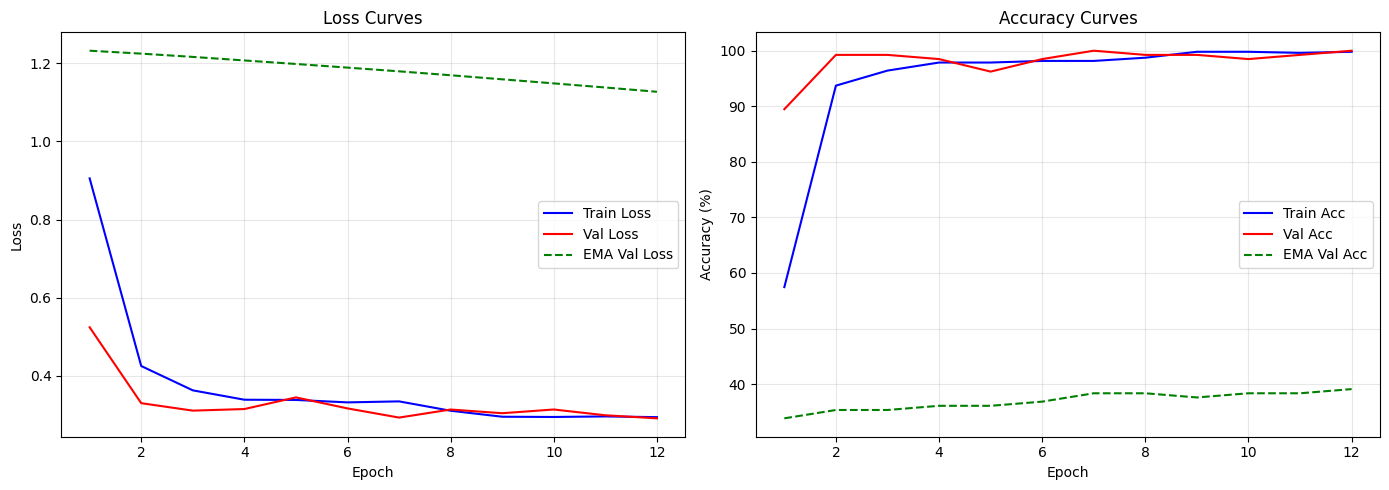

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss')
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss')
axes[0].plot(epochs_range, history['ema_val_loss'], 'g--', label='EMA Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train Acc')
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val Acc')
axes[1].plot(epochs_range, history['ema_val_acc'], 'g--', label='EMA Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/deit_training_curves.png', dpi=150)
plt.show()

Biểu đồ cho thấy model DeiT học cực kỳ nhanh và ổn định. Loss Curves: Train loss (xanh) giảm mạnh từ 0.9 xuống ~0.3, Val loss (đỏ) giảm từ 0.52 xuống ~0.29 và hội tụ song song với train loss - dấu hiệu không overfitting. EMA Val loss (xanh lá) giữ nguyên ở mức cao (~1.2) do không đủ thời gian tích lũy. Accuracy Curves: Val accuracy đạt ~90% ngay epoch 1, tăng lên 99-100% từ epoch 2 và duy trì ổn định. Train accuracy theo sau và hội tụ với val accuracy ở mức ~100%. Sự chênh lệch lớn giữa EMA (~39%) và model gốc cho thấy với dataset nhỏ và training ngắn, EMA không phát huy hiệu quả - chiến lược lưu model gốc thay vì EMA là quyết định đúng đắn.

## Final Evaluation

In [12]:
if os.path.exists(f'{OUTPUT_DIR}/best_deit_ema.pth'):
    model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_deit_ema.pth'))
    print('Loaded best EMA model')
elif os.path.exists(f'{OUTPUT_DIR}/best_deit.pth'):
    model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_deit.pth'))
    print('Loaded best model')

model.eval()
_, final_acc, final_preds, final_labels = validate(model, val_loader, criterion, device)

print(f'\nFinal Validation Accuracy: {final_acc:.2f}%')

Loaded best model


Validating:   0%|          | 0/5 [00:00<?, ?it/s]


Final Validation Accuracy: 100.00%



Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       1.00      1.00      1.00        44
        bean_rust       1.00      1.00      1.00        45
          healthy       1.00      1.00      1.00        44

         accuracy                           1.00       133
        macro avg       1.00      1.00      1.00       133
     weighted avg       1.00      1.00      1.00       133



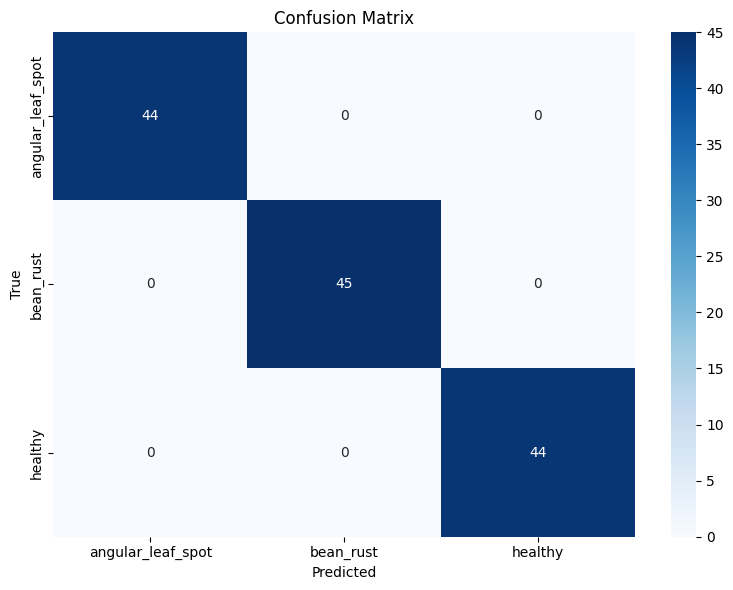

In [13]:
print('\nClassification Report:')
print(classification_report(final_labels, final_preds, target_names=class_names))

cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/deit_confusion_matrix.png', dpi=150)
plt.show()

kết quả trên tập val đạt kết quả 100%

In [14]:
import json

results = {
    'best_val_acc': best_acc,
    'final_val_acc': final_acc,
    'epochs_trained': len(history['train_loss']),
    'history': history
}

with open(f'{OUTPUT_DIR}/deit_training_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f'Results saved to {OUTPUT_DIR}/deit_training_results.json')

Results saved to /kaggle/working/results/deit_training_results.json


In [15]:
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import StratifiedKFold
import timm
from timm.utils import ModelEmaV2
import os
from torchvision import datasets, transforms

N_SPLITS = 5
SEED = 42

def seed_everything(seed):
    import random
    import os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# ================= DATASET WRAPPER =================
class DatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# ================= MAIN K-FOLD LOOP =================
if os.path.exists(TRAIN_DIR) and os.path.exists(VAL_DIR):
    # 1. Load Raw Data (Chưa transform)
    ds_train_raw = datasets.ImageFolder(TRAIN_DIR, transform=None)
    ds_val_raw = datasets.ImageFolder(VAL_DIR, transform=None)
    
    # Kiểm tra class mapping
    if ds_train_raw.class_to_idx != ds_val_raw.class_to_idx:
        raise ValueError("Class mapping không khớp giữa Train và Val!")

    # Gộp dataset
    full_dataset = ConcatDataset([ds_train_raw, ds_val_raw])
    
    # Lấy toàn bộ targets để chia Stratified
    all_targets = ds_train_raw.targets + ds_val_raw.targets
    
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    cv_results = {}

    print(f'\nStarting {N_SPLITS}-Fold Cross-Validation...')

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_targets)), all_targets)):
        print(f'\n{"="*15} FOLD {fold+1}/{N_SPLITS} {"="*15}')
        
        # --- CLEANUP MEMORY ---
        if 'model' in globals(): del model
        if 'model_ema' in globals(): del model_ema
        if 'optimizer' in globals(): del optimizer
        if 'scheduler' in globals(): del scheduler
        torch.cuda.empty_cache()
        gc.collect()
        
        # --- PREPARE DATA ---
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)
        
        # Áp dụng Transform riêng biệt (Train có Augmentation, Val thì không)
        train_data = DatasetWrapper(train_subset, data_transforms['train'])
        val_data = DatasetWrapper(val_subset, data_transforms['val'])
        
        train_loader_cv = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_loader_cv = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
        
        # --- INIT MODEL ---
        model = timm.create_model(
            'deit3_small_patch16_384.fb_in1k',
            pretrained=True,
            num_classes=NUM_CLASSES
        )
        model = model.to(device)
        
        model_ema = ModelEmaV2(model, decay=EMA_DECAY, device=device)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        
        # Recalculate scheduler steps
        total_steps = len(train_loader_cv) * NUM_EPOCHS
        warmup_steps = len(train_loader_cv) * WARMUP_EPOCHS
        
        def lr_lambda_cv(current_step):
            if current_step < warmup_steps:
                return float(current_step) / float(max(1, warmup_steps))
            progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))
            
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda_cv)
        
        # --- TRAINING LOOP ---
        best_fold_acc = 0.0
        patience_counter = 0
        
        for epoch in range(NUM_EPOCHS):
            # Hàm train_one_epoch
            train_loss, train_acc = train_one_epoch(
                model, model_ema, train_loader_cv, criterion, optimizer, scheduler, device
            )
            
            val_loss, val_acc, _, _ = validate(model, val_loader_cv, criterion, device)
            
            
            # Checkpoint dựa trên Acc của Model chính
            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                patience_counter = 0
                torch.save(model.state_dict(), f'{OUTPUT_DIR}/deit_fold_{fold+1}_best.pth')
                # print(f'Saved best model Fold {fold+1}: {best_fold_acc:.2f}%')
            else:
                patience_counter += 1
                
            print(f' Ep {epoch+1}: Train Loss {train_loss:.4f} Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}% | Best: {best_fold_acc:.2f}%')
            
            if patience_counter >= PATIENCE:
                print(f' Early stopping at epoch {epoch+1}')
                break
        
        print(f'Finished Fold {fold+1}. Best Acc: {best_fold_acc:.2f}%')
        cv_results[f'fold_{fold+1}'] = best_fold_acc

    # Summary
    print('\n=== Cross-Validation Results ===')
    accs = list(cv_results.values())
    print(f'Fold Accuracies: {accs}')
    print(f'Mean Accuracy: {np.mean(accs):.2f}% (+/- {np.std(accs):.2f}%)')
    
    import json
    with open(f'{OUTPUT_DIR}/cv_results_final.json', 'w') as f:
        json.dump(cv_results, f, indent=4)

else:
    print('Error: Data directories not found.')


Starting 5-Fold Cross-Validation...

=============== FOLD 1/5 ===============


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 1: Train Loss 0.9167 Acc 57.66% | Val Acc 82.48% | Best: 82.48%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 2: Train Loss 0.4786 Acc 89.17% | Val Acc 95.73% | Best: 95.73%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 3: Train Loss 0.3901 Acc 96.03% | Val Acc 96.15% | Best: 96.15%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 4: Train Loss 0.3637 Acc 96.57% | Val Acc 94.02% | Best: 96.15%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 5: Train Loss 0.3351 Acc 97.64% | Val Acc 93.16% | Best: 96.15%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     

Training:   0%|          | 0/30 [00:00<?, ?it/s]

  ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 6: Train Loss 0.3582 Acc 96.78% | Val Acc 96.58% | Best: 96.58%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 7: Train Loss 0.3065 Acc 99.46% | Val Acc 97.01% | Best: 97.01%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 8: Train Loss 0.2964 Acc 99.68% | Val Acc 96.58% | Best: 97.01%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 9: Train Loss 0.3090 Acc 99.36% | Val Acc 97.86% | Best: 97.86%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 10: Train Loss 0.3050 Acc 99.14% | Val Acc 97.44% | Best: 97.86%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 11: Train Loss 0.3013 Acc 99.57% | Val Acc 96.15% | Best: 97.86%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 12: Train Loss 0.2934 Acc 99.89% | Val Acc 97.86% | Best: 97.86%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 13: Train Loss 0.2917 Acc 100.00% | Val Acc 97.86% | Best: 97.86%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 14: Train Loss 0.2919 Acc 100.00% | Val Acc 97.86% | Best: 97.86%
 Early stopping at epoch 14
Finished Fold 1. Best Acc: 97.86%

=============== FOLD 2/5 ===============


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 1: Train Loss 0.8479 Acc 66.56% | Val Acc 92.74% | Best: 92.74%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 2: Train Loss 0.4043 Acc 95.18% | Val Acc 98.29% | Best: 98.29%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 3: Train Loss 0.3402 Acc 98.18% | Val Acc 96.15% | Best: 98.29%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 4: Train Loss 0.3327 Acc 97.75% | Val Acc 96.58% | Best: 98.29%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 5: Train Loss 0.3347 Acc 97.75% | Val Acc 97.44% | Best: 98.29%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 6: Train Loss 0.3131 Acc 99.04% | Val Acc 98.72% | Best: 98.72%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 7: Train Loss 0.3313 Acc 97.96% | Val Acc 99.15% | Best: 99.15%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 8: Train Loss 0.3019 Acc 99.68% | Val Acc 98.29% | Best: 99.15%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 9: Train Loss 0.3093 Acc 99.04% | Val Acc 97.44% | Best: 99.15%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 10: Train Loss 0.3242 Acc 98.50% | Val Acc 96.58% | Best: 99.15%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 11: Train Loss 0.2971 Acc 99.68% | Val Acc 98.72% | Best: 99.15%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 12: Train Loss 0.3063 Acc 99.36% | Val Acc 98.72% | Best: 99.15%
 Early stopping at epoch 12
Finished Fold 2. Best Acc: 99.15%

=============== FOLD 3/5 ===============


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 1: Train Loss 0.8863 Acc 62.31% | Val Acc 76.39% | Best: 76.39%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 2: Train Loss 0.4315 Acc 93.58% | Val Acc 93.56% | Best: 93.56%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 3: Train Loss 0.3612 Acc 96.36% | Val Acc 98.28% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 4: Train Loss 0.3503 Acc 97.00% | Val Acc 91.85% | Best: 98.28%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^

Training:   0%|          | 0/30 [00:00<?, ?it/s]

^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():  
 ^ ^ ^ ^^^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^   ^ ^    ^ 
AssertionError : can only test a child process^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 5: Train Loss 0.3243 Acc 98.72% | Val Acc 98.28% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 6: Train Loss 0.3102 Acc 99.25% | Val Acc 97.85% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 7: Train Loss 0.3061 Acc 99.04% | Val Acc 97.00% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 8: Train Loss 0.3161 Acc 98.61% | Val Acc 97.85% | Best: 98.28%
 Early stopping at epoch 8
Finished Fold 3. Best Acc: 98.28%

=============== FOLD 4/5 ===============


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 1: Train Loss 0.8469 Acc 65.85% | Val Acc 92.70% | Best: 92.70%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 2: Train Loss 0.4029 Acc 94.22% | Val Acc 97.85% | Best: 97.85%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 3: Train Loss 0.3367 Acc 97.97% | Val Acc 85.84% | Best: 97.85%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     ^  ^^

Training:   0%|          | 0/30 [00:00<?, ?it/s]

^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^^self._shutdown_workers()

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

                 ^^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^  ^^  ^^ ^  ^  ^ ^^^^^^^^^^^^
^^AssertionError: can only test a child process
^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 4: Train Loss 0.3566 Acc 96.79% | Val Acc 97.85% | Best: 97.85%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 5: Train Loss 0.3262 Acc 98.50% | Val Acc 98.28% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 6: Train Loss 0.3272 Acc 98.50% | Val Acc 97.42% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 7: Train Loss 0.3410 Acc 97.75% | Val Acc 97.85% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 8: Train Loss 0.3330 Acc 98.07% | Val Acc 97.00% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 9: Train Loss 0.3005 Acc 99.68% | Val Acc 97.85% | Best: 98.28%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 10: Train Loss 0.2999 Acc 99.68% | Val Acc 97.85% | Best: 98.28%
 Early stopping at epoch 10
Finished Fold 4. Best Acc: 98.28%

=============== FOLD 5/5 ===============


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 1: Train Loss 0.9233 Acc 58.78% | Val Acc 84.55% | Best: 84.55%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 2: Train Loss 0.4164 Acc 93.90% | Val Acc 96.14% | Best: 96.14%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 3: Train Loss 0.3724 Acc 96.15% | Val Acc 96.57% | Best: 96.57%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 4: Train Loss 0.3565 Acc 97.00% | Val Acc 97.85% | Best: 97.85%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 5: Train Loss 0.3229 Acc 98.82% | Val Acc 97.85% | Best: 97.85%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 6: Train Loss 0.3268 Acc 98.29% | Val Acc 93.56% | Best: 97.85%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x781770f2c220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 7: Train Loss 0.3163 Acc 98.93% | Val Acc 88.41% | Best: 97.85%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 8: Train Loss 0.3219 Acc 98.61% | Val Acc 94.42% | Best: 97.85%


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

 Ep 9: Train Loss 0.3220 Acc 98.72% | Val Acc 96.14% | Best: 97.85%
 Early stopping at epoch 9
Finished Fold 5. Best Acc: 97.85%

=== Cross-Validation Results ===
Fold Accuracies: [97.86324786324786, 99.14529914529915, 98.28326180257511, 98.28326180257511, 97.85407725321889]
Mean Accuracy: 98.29% (+/- 0.47%)


Model DeiT3-Small đạt 100% accuracy trên hold-out validation và 98.29% ± 0.47% trên 5-Fold CV. Fold cao nhất đạt 99.15%, độ lệch chuẩn thấp (0.47%) cho thấy model học ổn định. So với MobileNetV3 (98.50% hold-out, 96.57% CV), DeiT vượt trội cả về accuracy lẫn độ ổn định.



In [16]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-_ihjzlkn
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-_ihjzlkn
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=208c8420a2a39ac2f93c165369ff294e40fa7c27cb420ed0047bfc9c8b6bfc4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-3tf0nrqh/wheels/69/29/f7/3abdb24031a22af044df15784c8a00f56b6e24f5924e33d0e8
Successfully built grad-cam



[1/4] Đang khởi tạo và load model...
 -> Đã load weights từ: /kaggle/working/results/best_deit.pth

[2/4] Chuẩn bị dữ liệu...

[3/4] Hiển thị mẫu kiểm tra nhanh...


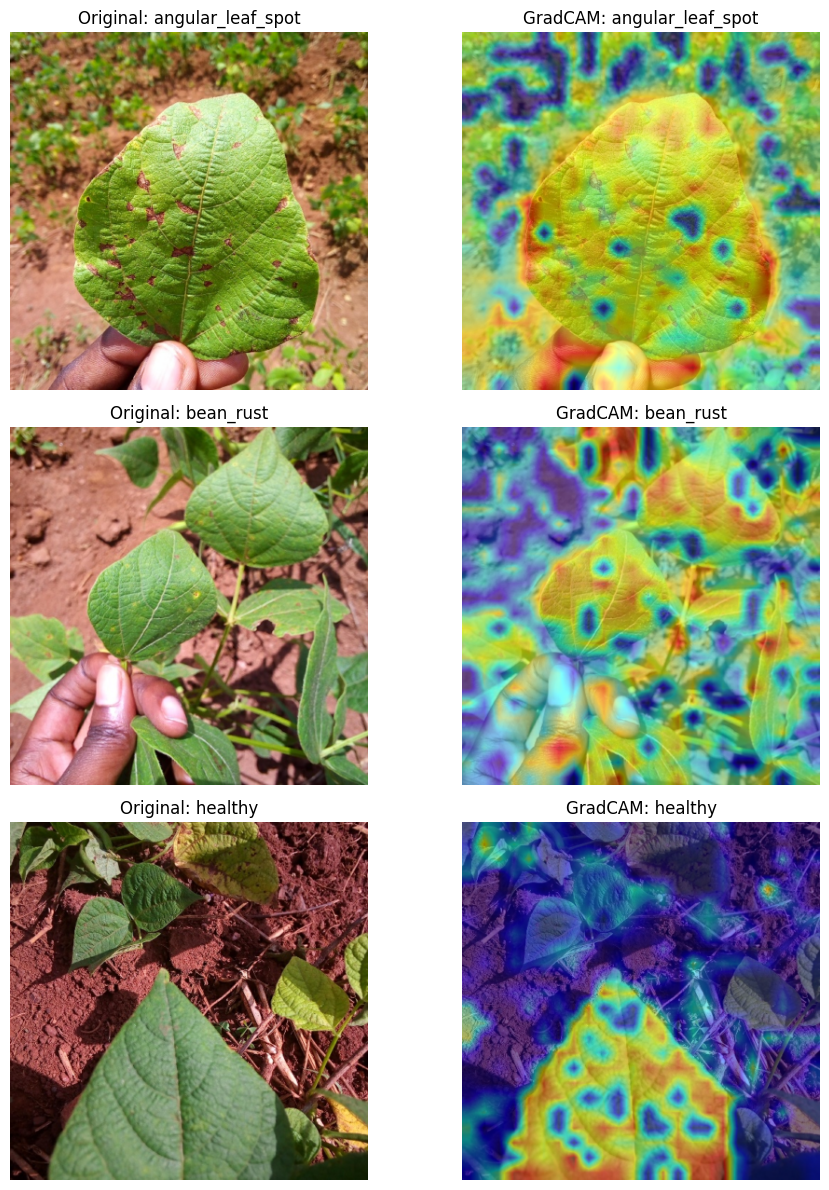


[4/4] Bắt đầu xuất toàn bộ ảnh GradCAM...

>>> Đang xử lý tập: VAL (133 ảnh)
    Lưu tại: /kaggle/working/results/gradcam_full_results/val


Processing val:   0%|          | 0/133 [00:00<?, ?it/s]


>>> Đang xử lý tập: TRAIN (1034 ảnh)
    Lưu tại: /kaggle/working/results/gradcam_full_results/train


Processing train:   0%|          | 0/1034 [00:00<?, ?it/s]


 Hoàn tất! Kiểm tra kết quả tại: /kaggle/working/results/gradcam_full_results


In [20]:
import os
import timm
from PIL import Image
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Hàm Reshape cho Vision Transformer ---
def reshape_transform(tensor):
    # Loại bỏ CLS token và reshape từ 1D sequence về 2D grid
    result = tensor[:, 1:, :]
    target_size = int(np.sqrt(result.size(1))) # Ví dụ: 384/16 = 24
    result = result.reshape(result.size(0), target_size, target_size, result.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# ==============================================================================
#  CORE VISUALIZATION FUNCTIONS
# ==============================================================================
def run_gradcam_on_dataset(model, dataset, device, base_output_dir, subset_name='val'):
    """
    Chạy GradCAM và lưu ảnh visualize cho toàn bộ dataset.
    """
    model.eval()
    output_dir = os.path.join(base_output_dir, subset_name)
    
    # Lấy class names
    class_names = dataset.classes if hasattr(dataset, 'classes') else ['angular_leaf_spot', 'bean_rust', 'healthy']
    
    # Tạo cấu trúc thư mục
    for cls in class_names:
        os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
            
    print(f"\n>>> Đang xử lý tập: {subset_name.upper()} ({len(dataset)} ảnh)")
    print(f"    Lưu tại: {output_dir}")

    # Cấu hình GradCAM cho DeiT
    target_layers = [model.blocks[-1].norm1]
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

    # Thông số Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Loop xử lý (Batch size = 1 để an toàn memory)
    for i in tqdm(range(len(dataset)), desc=f"Processing {subset_name}"):
        try:
            # Lấy dữ liệu
            img_tensor, label = dataset[i][0], dataset[i][1]
            label_idx = int(label) if not isinstance(label, torch.Tensor) else label.item()
            class_name = class_names[label_idx]

            # Chạy GradCAM
            input_tensor = img_tensor.unsqueeze(0).to(device)
            targets = [ClassifierOutputTarget(label_idx)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

            # Xử lý ảnh gốc để hiển thị (Denormalize)
            rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
            rgb_img = np.clip(rgb_img * std + mean, 0, 1)
            
            # Tạo ảnh kết quả
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            
            # Lưu ảnh
            save_path = os.path.join(output_dir, class_name, f"{subset_name}_{i:04d}.jpg")
            Image.fromarray(visualization).save(save_path)

        except Exception as e:
            continue

def visualize_samples(model, dataset, device, num_samples_per_class=1):
    """Hiển thị nhanh mẫu GradCAM trực tiếp trên notebook"""
    model.eval()
    required_labels = {0, 1, 2}
    found_indices = {}
    class_names = dataset.classes if hasattr(dataset, 'classes') else ['angular_leaf_spot', 'bean_rust', 'healthy']

    # Tìm ảnh đại diện
    for i in range(len(dataset)):
        lbl = int(dataset[i][1]) if not isinstance(dataset[i][1], torch.Tensor) else dataset[i][1].item()
        if lbl in required_labels and lbl not in found_indices:
            found_indices[lbl] = i
        if len(found_indices) == len(required_labels): break

    if not found_indices: return

    # Vẽ biểu đồ
    fig, axes = plt.subplots(len(found_indices), 2, figsize=(10, 4 * len(found_indices)))
    if len(found_indices) == 1: axes = [axes]
    
    target_layers = [model.blocks[-1].norm1]
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])

    for row, (lbl, idx) in enumerate(sorted(found_indices.items())):
        img_tensor = dataset[idx][0]
        input_tensor = img_tensor.unsqueeze(0).to(device)
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(lbl)])[0, :]
        
        rgb_img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy() * std + mean, 0, 1)
        viz = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        # Cột 1: Gốc, Cột 2: GradCAM
        axes[row][0].imshow(rgb_img); axes[row][0].set_title(f"Original: {class_names[lbl]}"); axes[row][0].axis('off')
        axes[row][1].imshow(viz); axes[row][1].set_title(f"GradCAM: {class_names[lbl]}"); axes[row][1].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Load Model ---
print("\n[1/4] Đang khởi tạo và load model...")
model_viz = timm.create_model('deit3_small_patch16_384.fb_in1k', pretrained=False, num_classes=NUM_CLASSES)
model_viz = model_viz.to(device)

    # Ưu tiên load theo thứ tự: EMA -> Best -> Fold
checkpoints = [
        f'{OUTPUT_DIR}/best_deit_ema.pth',
        f'{OUTPUT_DIR}/best_deit.pth',
        f'{OUTPUT_DIR}/deit_fold_1_best.pth'
]
    
loaded = False
for ckpt in checkpoints:
    if os.path.exists(ckpt):
            model_viz.load_state_dict(torch.load(ckpt, map_location=device))
            print(f" -> Đã load weights từ: {ckpt}")
            loaded = True
            break


# --- Prepare Data (Luôn dùng Val Transform để ảnh không bị méo) ---
print("\n[2/4] Chuẩn bị dữ liệu...")
# Lưu ý: Dùng data_transforms['val'] cho cả tập Train để visualization chính xác
viz_val_ds = datasets.ImageFolder(VAL_DIR, transform=data_transforms['val'])
viz_train_ds = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['val']) 

# ---  Quick Sanity Check ---
print("\n[3/4] Hiển thị mẫu kiểm tra nhanh...")
visualize_samples(model_viz, viz_val_ds, device)

# ---  Batch Processing (Save All) ---
print("\n[4/4] Bắt đầu xuất toàn bộ ảnh GradCAM...")
ROOT_OUTPUT_CAM = os.path.join(OUTPUT_DIR, 'gradcam_full_results')
    
# 1. Chạy tập Validation
run_gradcam_on_dataset(model_viz, viz_val_ds, device, ROOT_OUTPUT_CAM, subset_name='val')
    
# 2. Chạy tập Training
run_gradcam_on_dataset(model_viz, viz_train_ds, device, ROOT_OUTPUT_CAM, subset_name='train')

print(f"\n Hoàn tất! Kiểm tra kết quả tại: {ROOT_OUTPUT_CAM}")

In [21]:
import shutil
import os
from IPython.display import FileLink

# Tên thư mục kết quả đang có
folder_to_zip = 'results'
# Tên file zip muốn tạo ra (không cần đuôi .zip)
output_filename = 'ketqua'

# 1. Nén thư mục
if os.path.exists(folder_to_zip):
    print("Đang nén file... Vui lòng chờ chút.")
    shutil.make_archive(output_filename, 'zip', folder_to_zip)
    zip_path = f"{output_filename}.zip"
    print(f"Đã nén xong: {zip_path}")
    
    # 2. Tạo đường dẫn tải xuống (Click vào link hiện ra bên dưới)
    print(" Click vào link dưới đây để tải về:")
    display(FileLink(zip_path))
else:
    print(f" Không tìm thấy thư mục {folder_to_zip}")

Đang nén file... Vui lòng chờ chút.
Đã nén xong: ketqua.zip
 Click vào link dưới đây để tải về:


/kaggle/working/ketqua.zip